# Training notebook
# Time frequency plots and inter trial coherence for Probability learning   

https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html 



# !!!!!! Inter-trial coherence is not supported with average=False !!!!!


In [2]:
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch, tfr_multitaper

import copy

import os

# Для одного испытуемого

In [54]:
subj = 'P001'
r = 2
cond = 'risk'
fb = 'negative'

L_freq = 2
H_freq = 41
f_step = 2
freqs = np.arange(L_freq, H_freq, f_step)
#for others
n_cycles = freqs//2

period_start = -1.750
period_end = 2.750

baseline = (-0.35, -0.05)

data_path = '/net/server/data/Archive/prob_learn/vtretyakova/ICA_cleaned'


# Загружаем данные для бейзлайн

In [4]:
events_pos = np.loadtxt("/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/fix_cross_mio_corr/{0}_run{1}_norisk_fb_cur_positive_fix_cross.txt".format(subj, r), dtype='int') 
if events_pos.shape == (3,):
    events_pos = events_pos.reshape(1,3)
        

In [5]:
events_neg = np.loadtxt("/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/fix_cross_mio_corr/{0}_run{1}_norisk_fb_cur_negative_fix_cross.txt".format(subj, r), dtype='int')
if events_neg.shape == (3,):
    events_neg = events_neg.reshape(1,3) 

In [6]:
#объединяем негативные и позитивные фидбеки для получения общего бейзлайна по ним, и сортируем массив, чтобы времена меток шли в порядке возрастания    
events = np.vstack([events_pos, events_neg])
events = np.sort(events, axis = 0) 

# Загружаем данные для анализа

In [7]:
#events, which we need
events_response = np.loadtxt('/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/events_by_cond_mio_corrected/{0}_run{1}_{2}_fb_cur_{3}.txt'.format(subj, r, cond, fb), dtype='int')
# если только одна метка, т.е. одна эпоха, то выдается ошибка, поэтому приводи shape к виду (N,3)
if events_response.shape == (3,):
    events_response = events_response.reshape(1,3)

In [8]:
raw_fname = op.join(data_path, '{0}/run{1}_{0}_raw_ica.fif'.format(subj, r))

raw_data = mne.io.Raw(raw_fname, preload=True)
        
    
picks = mne.pick_types(raw_data.info, meg = True, eog = True)

Opening raw data file /net/server/data/Archive/prob_learn/vtretyakova/ICA_cleaned/P001/run2_P001_raw_ica.fif...


/tmp/ipykernel_1568406/1922448513.py:3: RuntimeWarning: This filename (/net/server/data/Archive/prob_learn/vtretyakova/ICA_cleaned/P001/run2_P001_raw_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_data = mne.io.Raw(raw_fname, preload=True)


    Range : 154000 ... 303999 =    154.000 ...   303.999 secs
Ready.
Reading 0 ... 149999  =      0.000 ...   149.999 secs...


# ############## Для бейзлайна 

In [91]:
#epochs for baseline
    # baseline = None, чтобы не вычитался дефолтный бейзлайн
epochs = mne.Epochs(raw_data, events, event_id = None, tmin = -1.0, tmax = 1.0, baseline = None, picks = picks, 
                    preload = True)
epochs.resample(300)

Not setting metadata
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Loading data for 25 events and 2001 original time points ...
0 bad epochs dropped


Number of events,25
Events,1: 25
Time range,-1.000 – 0.997 sec
Baseline,off


In [92]:
freq_show_baseline = tfr_multitaper(epochs, freqs = freqs, n_cycles = n_cycles, use_fft = False, return_itc = False,
                                    average=True).crop(tmin=baseline[0], tmax=baseline[1], include_tmax=True) #frequency of baseline



In [93]:
freq_show_baseline.data.shape

(306, 20, 91)

In [94]:
freq_show_baseline_mean = freq_show_baseline.data.mean(axis = -1)
freq_show_baseline_mean.shape

(306, 20)

In [95]:
freq_show_baseline_mean_reshape = freq_show_baseline_mean[:, :, np.newaxis]
freq_show_baseline_mean_reshape.shape

(306, 20, 1)

# ###### ДЛЯ ДАННЫХ ##############

In [96]:
# baseline = None, чтобы не вычитался дефолтный бейзлайн
epochs = mne.Epochs(raw_data, events_response, event_id = None, tmin = period_start, 
		                tmax = period_end, baseline = None, picks = picks, preload = True)
		       
epochs.resample(300) 

freq_show, itc = mne.time_frequency.tfr_multitaper(epochs, freqs = freqs, n_cycles = n_cycles, use_fft = False,
                                              return_itc = True, average=True)

Not setting metadata
Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2 events and 4501 original time points ...
0 bad epochs dropped


In [61]:
freq_show.data.shape

(306, 20, 1350)

In [62]:
itc.data.shape

(306, 20, 1350)

In [63]:
data = 10*np.log10(freq_show.data/freq_show_baseline_mean_reshape)
data.shape

(306, 20, 1350)

#  Проверка вычитания бэйзлайн 

In [97]:
freq_show_baseline_mean_reshape[0][0].shape

(1,)

In [98]:
freq_show_baseline_mean_reshape[0][0]

array([1.07851562e-22])

In [99]:
freq_show.data[0][0]

array([9.44200407e-23, 9.72976260e-23, 1.00074119e-22, ...,
       6.75762405e-23, 6.46028120e-23, 6.13564935e-23])

In [100]:
a = freq_show.data - freq_show_baseline_mean_reshape
a.shape

(306, 20, 1350)

In [101]:
a[0][0]

array([-1.34315209e-23, -1.05539357e-23, -7.77744224e-24, ...,
       -4.02753211e-23, -4.32487496e-23, -4.64950681e-23])

# Конец проверки

In [64]:
freq_show.data = data

In [65]:
freq_show.save('/home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/train.h5', overwrite=True)

In [66]:
tfr = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/train.h5', condition=None)
tfr1 = tfr[0]

Reading /home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/train.h5 ...


/tmp/ipykernel_1568406/2322517142.py:1: RuntimeWarning: This filename (/home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/train.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  tfr = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/train.h5', condition=None)


In [67]:
tfr

[<AverageTFR | time : [-1.750000, 2.746667], freq : [2.000000, 40.000000], nave : 2, channels : 306, ~68.4 MB>]

In [68]:
tfr1

<AverageTFR | time : [-1.750000, 2.746667], freq : [2.000000, 40.000000], nave : 2, channels : 306, ~68.4 MB>

In [69]:
tfr1.data.shape

(306, 20, 1350)

# Saving ITC 

In [70]:
itc.save('/home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/itc_train.h5', overwrite=True)

In [71]:
itc_read = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/itc_train.h5', condition=None)




Reading /home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/itc_train.h5 ...


/tmp/ipykernel_1568406/1696156417.py:1: RuntimeWarning: This filename (/home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/itc_train.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  itc_read = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/itc_train.h5', condition=None)


In [72]:
itc_read

[<AverageTFR | time : [-1.750000, 2.746667], freq : [2.000000, 40.000000], nave : 2, channels : 306, ~68.4 MB>]

In [73]:
itc_read[0]

<AverageTFR | time : [-1.750000, 2.746667], freq : [2.000000, 40.000000], nave : 2, channels : 306, ~68.4 MB>

# Combained planars

# TF Data

In [74]:
ep_TFR_planar1 = tfr1.copy(); 
ep_TFR_planar2 = tfr1.copy();
ep_TFR_planar1.pick_types(meg='planar1')
ep_TFR_planar2.pick_types(meg='planar2')

#grad_RMS = np.power((np.power(evk_planar1.data, 2) + np.power(evk_planar2.data, 2)), 1/2)
combine = ep_TFR_planar1.data + ep_TFR_planar2.data

In [75]:
freq_range = '2_40_step_2_time_bandwidth_by_default_4_early_log'
donor = mne.time_frequency.read_tfrs('/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/{0}/donor_planar1_evoked.h5'.format(freq_range), condition=None)[0]
donor.data.shape

Reading /net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/2_40_step_2_time_bandwidth_by_default_4_early_log/donor_planar1_evoked.h5 ...


/tmp/ipykernel_1568406/3185066664.py:2: RuntimeWarning: This filename (/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/2_40_step_2_time_bandwidth_by_default_4_early_log/donor_planar1_evoked.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  donor = mne.time_frequency.read_tfrs('/net/server/data/Archive/prob_learn/vtretyakova/Nikita_mio_cleaned/tfr_plots/{0}/donor_planar1_evoked.h5'.format(freq_range), condition=None)[0]


(102, 20, 1350)

In [76]:
donor.data = combine

In [77]:
donor.save('/home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/comb_planar_train.h5', overwrite=True)

In [78]:
donor = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/comb_planar_train.h5', condition=None)[0]



Reading /home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/comb_planar_train.h5 ...


/tmp/ipykernel_1568406/1332895749.py:1: RuntimeWarning: This filename (/home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/comb_planar_train.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  donor = mne.time_frequency.read_tfrs('/home/vtretyakova/Рабочий стол/probabitily_teta/TF_plots/comb_planar_train.h5', condition=None)[0]


No baseline correction applied


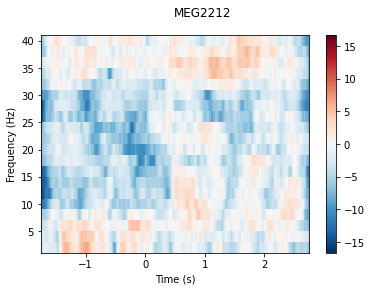

[<Figure size 432x288 with 2 Axes>]

In [80]:
donor.plot([82], baseline=None, title=donor.ch_names[82])

In [81]:
ITC_planar1 = itc.copy(); 
ITC_planar2 = itc.copy();
ITC_planar1.pick_types(meg='planar1')
ITC_planar2.pick_types(meg='planar2')

<AverageTFR | time : [-1.750000, 2.746667], freq : [2.000000, 40.000000], nave : 2, channels : 102, ~26.0 MB>

No baseline correction applied


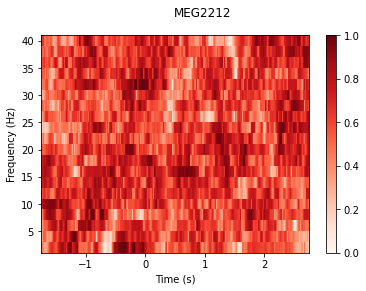

[<Figure size 432x288 with 2 Axes>]

In [85]:
ITC_planar1.plot([82], baseline=None, title=ITC_planar1.ch_names[82], vmin=0., vmax=1., cmap='Reds')

No baseline correction applied


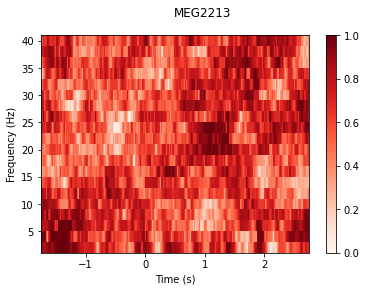

[<Figure size 432x288 with 2 Axes>]

In [86]:
ITC_planar2.plot([82], baseline=None, title=ITC_planar2.ch_names[82], vmin=0., vmax=1., cmap='Reds')